In [1]:
#install and initialize the library for monitoring the GPU
!pip install pynvml
from pynvml import *

nvmlInit()
handle = nvmlDeviceGetHandleByIndex(0)


In [2]:
import time
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_dataset
from transformers import AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)


Device: cuda


In [3]:
raw_ds = load_dataset('ag_news')
TOKENIZER_NAME = 'bert-base-uncased'
MAX_LEN = 64
BATCH_SIZE = 64


tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)



def tokenize_batch(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=MAX_LEN)

raw_ds = raw_ds.map(tokenize_batch, batched=True)
raw_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
train_loader = DataLoader(raw_ds['train'], batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(raw_ds['test'], batch_size=1, shuffle=False) # we'll do per-sample inference later


print('Dataset ready. Vocab size:', tokenizer.vocab_size)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset ready. Vocab size: 30522


In [4]:
class EarlyExitTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=4, dim_feedforward=256, num_layers=6,
                 exit_layer_indices=None, max_len=MAX_LEN, num_classes=4, pad_token_id=0):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.token_embed = nn.Embedding(vocab_size, d_model, padding_idx=pad_token_id)
        self.pos_embed = nn.Embedding(max_len, d_model)
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, activation='relu')
            for _ in range(num_layers)
        ])
        if exit_layer_indices is None:
            # default: 3 exit points evenly spaced (0-indexed)
            exit_layer_indices = [num_layers//3 - 1, 2*num_layers//3 - 1, num_layers - 1]
        self.exit_layer_indices = exit_layer_indices
        self.classifiers = nn.ModuleList([nn.Linear(d_model, num_classes) for _ in exit_layer_indices])
        self.num_layers = num_layers
        self.max_len = max_len

    def forward_full(self, input_ids, attention_mask):
        # input_ids: [batch, seq_len], attention_mask: [batch, seq_len]
        batch, seq_len = input_ids.size()
        device = input_ids.device
        pos_ids = torch.arange(seq_len, dtype=torch.long, device=device).unsqueeze(0).expand(batch, -1)

        x = self.token_embed(input_ids) + self.pos_embed(pos_ids)
        # Transformer expects (seq, batch, d_model)
        x = x.transpose(0,1)

        logits_list = []
        exit_idx = 0
        for layer_idx, layer in enumerate(self.layers):
            # src_key_padding_mask expects True at positions that are masked (i.e., pad tokens)
            src_key_padding_mask = (attention_mask == 0)
            x = layer(x, src_key_padding_mask=src_key_padding_mask)
            if layer_idx in self.exit_layer_indices:
                # pool: mean pooling over non-padded tokens
                x_t = x.transpose(0,1)  # [batch, seq, d]
                mask = attention_mask.unsqueeze(-1).float()  # [batch, seq, 1]
                summed = (x_t * mask).sum(dim=1)  # [batch, d]
                lengths = mask.sum(dim=1).clamp(min=1.0)  # avoid div by zero
                pooled = summed / lengths
                logits = self.classifiers[exit_idx](pooled)
                logits_list.append(logits)
                exit_idx += 1
        return logits_list  # list of tensors [batch, num_classes]

    def predict_until_exit(self, input_ids, attention_mask, tau=0.9):
        # Per-sample early exit inference (sequentially run layers until confidence >= tau).
        # Returns predicted label, confidence, exit_layer_index (actual layer index used)
        device = input_ids.device
        batch, seq_len = input_ids.size()
        assert batch == 1, 'predict_until_exit is implemented for single sample (batch=1)'

        pos_ids = torch.arange(seq_len, dtype=torch.long, device=device).unsqueeze(0)
        x = self.token_embed(input_ids) + self.pos_embed(pos_ids)
        x = x.transpose(0,1)  # [seq, 1, d]
        src_key_padding_mask = (attention_mask == 0)

        exit_idx = 0
        for layer_idx, layer in enumerate(self.layers):
            x = layer(x, src_key_padding_mask=src_key_padding_mask)
            if layer_idx in self.exit_layer_indices:
                x_t = x.transpose(0,1)  # [1, seq, d]
                mask = attention_mask.unsqueeze(-1).float()
                summed = (x_t * mask).sum(dim=1)
                lengths = mask.sum(dim=1).clamp(min=1.0)
                pooled = summed / lengths
                logits = self.classifiers[exit_idx](pooled)
                probs = F.softmax(logits, dim=1)
                conf, pred = torch.max(probs, dim=1)
                conf_val = conf.item()
                pred_val = pred.item()
                if conf_val >= tau:
                    return logits, layer_idx, conf_val
                exit_idx += 1
        # no early exit -> return final head's output
        # use last classifier's logits
        logits = logits.detach()
        probs = F.softmax(logits, dim=1)
        conf, pred = torch.max(probs, dim=1)
        return logits, self.num_layers - 1, conf.item()


In [5]:
NUM_LAYERS = 6
EXIT_LAYERS = [1, 3, 5]  # 0-indexed; will place classifiers after these layers
model = EarlyExitTransformer(vocab_size=tokenizer.vocab_size, d_model=128, nhead=4,
                             dim_feedforward=256, num_layers=NUM_LAYERS,
                             exit_layer_indices=EXIT_LAYERS, max_len=MAX_LEN,
                             num_classes=4, pad_token_id=tokenizer.pad_token_id)
model.to(device)

print(model)



EarlyExitTransformer(
  (token_embed): Embedding(30522, 128, padding_idx=0)
  (pos_embed): Embedding(64, 128)
  (layers): ModuleList(
    (0-5): 6 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (linear1): Linear(in_features=128, out_features=256, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=256, out_features=128, bias=True)
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (classifiers): ModuleList(
    (0-2): 3 x Linear(in_features=128, out_features=4, bias=True)
  )
)


In [6]:
LOAD_CHECKPOINT = False  #  set False if you want to retrain from scratch

model = EarlyExitTransformer(
    vocab_size=tokenizer.vocab_size,
    d_model=128,
    nhead=4,
    dim_feedforward=256,
    num_layers=NUM_LAYERS,
    exit_layer_indices=EXIT_LAYERS,
    max_len=MAX_LEN,
    num_classes=4,
    pad_token_id=tokenizer.pad_token_id
).to(device)

if LOAD_CHECKPOINT:
    model.load_state_dict(torch.load("early_exit_model.pt", map_location=device))
    model.eval()
    print("Loaded pretrained checkpoint ")
else:
    print("Training from scratch… run Cell 5 next.")


Training from scratch… run Cell 5 next.


In [7]:
if not LOAD_CHECKPOINT:
    EPOCHS = 3
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    num_exits = len(EXIT_LAYERS)
    weights = [1.0/num_exits] * num_exits  # equal weights

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0.0
        total_samples = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits_list = model.forward_full(input_ids, attention_mask)

            # combine losses from all exits
            loss = sum(weights[i] * F.cross_entropy(logits, labels)
                       for i, logits in enumerate(logits_list))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * input_ids.size(0)
            total_samples += input_ids.size(0)

        print(f"Epoch {epoch+1}/{EPOCHS}, Avg Loss: {total_loss/total_samples:.4f}")


    torch.save(model.state_dict(), "early_exit_model.pt")
    print("Model saved ")


Epoch 1/3, Avg Loss: 0.4779
Epoch 2/3, Avg Loss: 0.2680
Epoch 3/3, Avg Loss: 0.2113
Model saved 


In [8]:
model.eval()
correct_full = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        logits_list = model.forward_full(input_ids, attention_mask)
        # use final exit's logits as baseline
        final_logits = logits_list[-1]
        preds = torch.argmax(final_logits, dim=1)
        correct_full += (preds == labels).sum().item()
        total += labels.size(0)
print(f"Full-model baseline accuracy: {correct_full/total:.4f} on test set")



Full-model baseline accuracy: 0.9067 on test set


In [9]:
taus = [round(t, 2) for t in np.linspace(0.5, 0.99, 10)]

results = {}

print("Evaluating early-exit model across tau thresholds...")
for tau in taus:
    correct, total = 0, 0
    total_layers, total_latency = 0, 0
    total_energy = 0
    exit_layers_used = []

    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # per-sample early exit
            for i in range(input_ids.size(0)):
                single_input = input_ids[i].unsqueeze(0)
                single_mask = attention_mask[i].unsqueeze(0)
                label = labels[i].unsqueeze(0)

                start = time.time()
                logits, exit_layer, conf = model.predict_until_exit(single_input, single_mask, tau=tau)
                latency = time.time() - start

                # --- NEW: ENERGY MEASUREMENT CODE STARTS HERE ---
                power_mW = nvmlDeviceGetPowerUsage(handle)
                power_W = power_mW / 1000  # Convert milliwatts to Watts
                energy_J = power_W * latency  # Energy (Joules) = Power (Watts) * Time (seconds)
                total_energy += energy_J
                # --- NEW: ENERGY MEASUREMENT CODE ENDS HERE ---

                pred = logits.argmax(dim=-1)
                correct += (pred == label).sum().item()
                total += 1

                total_layers += exit_layer
                total_latency += latency
                exit_layers_used.append(exit_layer)

    acc = correct / total
    avg_layers = total_layers / total
    avg_latency = total_latency /total
    avg_energy = total_energy / total

    results[tau] = {
        "accuracy": acc,
        "avg_layers": avg_layers,
        "latency_s": avg_latency,
        "avg_energy_J": avg_energy,
        "exit_layers_used": exit_layers_used
    }
    print(f"tau={tau:.2f}: acc={acc:.4f}, avg_layers={avg_layers:.2f}, latency={avg_latency*1000:.2f} ms")

#  Baseline (full model, no early exit)
model.eval()
correct_full, total = 0, 0
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        logits_list = model.forward_full(input_ids, attention_mask)
        logits = logits_list[-1]  # final exit only
        preds = logits.argmax(dim=-1)

        correct_full += (preds == labels).sum().item()
        total += labels.size(0)

baseline_acc = correct_full / total
baseline_layers = NUM_LAYERS
# approximate latency scaling
baseline_latency = np.mean([results[t]["latency_s"] for t in taus]) * (baseline_layers / np.mean([results[t]["avg_layers"] for t in taus]))

print(f"\nFull-model baseline accuracy: {baseline_acc:.4f}")

# Approximate energy scaling
baseline_energy = np.mean([results[t]["avg_energy_J"] for t in taus]) * (baseline_layers / np.mean([results[t]["avg_layers"] for t in taus]))

print(f"Approximated baseline energy: {baseline_energy:.4f} J")


Evaluating early-exit model across tau thresholds...
tau=0.50: acc=0.9103, avg_layers=1.04, latency=1.74 ms
tau=0.55: acc=0.9082, avg_layers=1.10, latency=1.82 ms
tau=0.61: acc=0.9068, avg_layers=1.19, latency=1.90 ms
tau=0.66: acc=0.9067, avg_layers=1.26, latency=1.98 ms
tau=0.72: acc=0.9067, avg_layers=1.35, latency=2.08 ms
tau=0.77: acc=0.9067, avg_layers=1.43, latency=2.05 ms
tau=0.83: acc=0.9067, avg_layers=1.55, latency=2.14 ms
tau=0.88: acc=0.9067, avg_layers=1.71, latency=2.29 ms
tau=0.94: acc=0.9067, avg_layers=2.08, latency=2.59 ms
tau=0.99: acc=0.9067, avg_layers=3.54, latency=5.20 ms

Full-model baseline accuracy: 0.9067
Approximated baseline energy: 0.2594 J


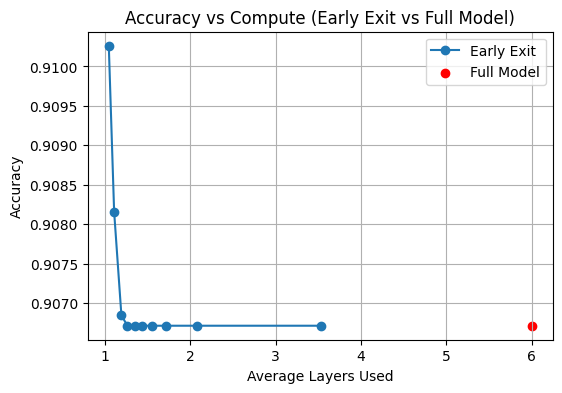

In [10]:
# Collect arrays for plotting
accs = [results[t]['accuracy'] for t in taus]
layers = [results[t]['avg_layers'] for t in taus]
latencies = [results[t]['latency_s']*1000 for t in taus]  # ms

# Accuracy vs Avg Layers Plot
plt.figure(figsize=(6,4))
plt.plot(layers, accs, marker='o', label='Early Exit')
plt.scatter([baseline_layers], [baseline_acc], color='red', label='Full Model')
plt.xlabel("Average Layers Used")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Compute (Early Exit vs Full Model)")
plt.legend()
plt.grid(True)
plt.show()


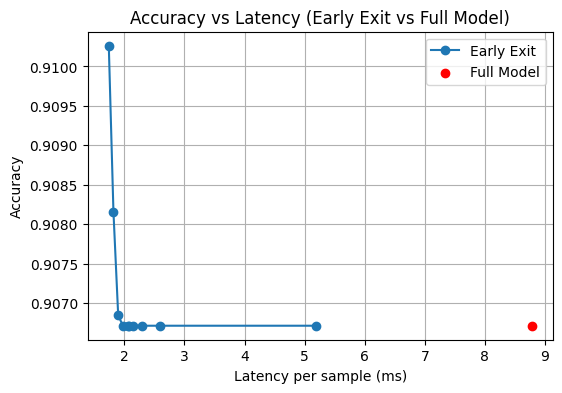

In [11]:
# Accuracy vs Latency Plot
plt.figure(figsize=(6,4))
plt.plot(latencies, accs, marker='o', label='Early Exit')
plt.scatter([baseline_latency*1000], [baseline_acc], color='red', label='Full Model')
plt.xlabel("Latency per sample (ms)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Latency (Early Exit vs Full Model)")
plt.legend()
plt.grid(True)
plt.show()


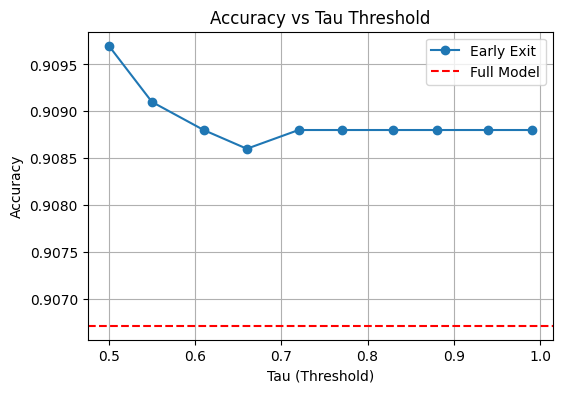

In [12]:
taus = [0.50, 0.55, 0.61, 0.66, 0.72, 0.77, 0.83, 0.88, 0.94, 0.99]
accs = [0.9097, 0.9091, 0.9088, 0.9086, 0.9088, 0.9088, 0.9088, 0.9088, 0.9088, 0.9088]

plt.figure(figsize=(6,4))
plt.plot(taus, accs, marker='o', label='Early Exit')
plt.axhline(y=baseline_acc, color='red', linestyle='--', label='Full Model')
plt.xlabel("Tau (Threshold)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Tau Threshold")
plt.legend()
plt.grid(True)
plt.show()


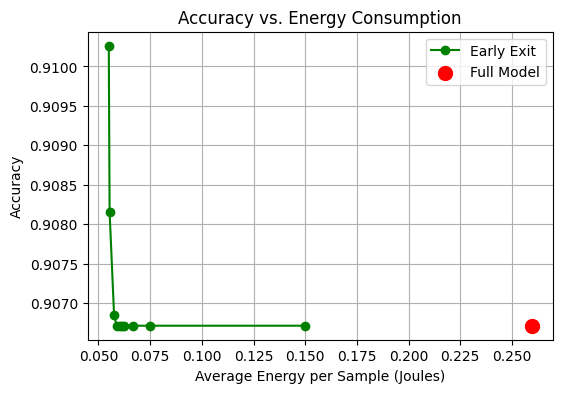

In [13]:
# --- Plotting Energy Results ---

# 1. Extract the energy data
energies_J = [results[t]['avg_energy_J'] for t in taus]
accs = [results[t]['accuracy'] for t in taus]

# 2. Create the plot
plt.figure(figsize=(6,4))
plt.plot(energies_J, accs, marker='o', label='Early Exit', color='green')

# 3. Add the baseline "Full Model" point for comparison
plt.scatter([baseline_energy], [baseline_acc], color='red', s=100, zorder=5, label='Full Model')

plt.xlabel("Average Energy per Sample (Joules)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Energy Consumption")
plt.legend()
plt.grid(True)
plt.show()